In [42]:
%cd Vehicles-Animals-Image-Classification-with-CIFAR-10



/content/Vehicles-Animals-Image-Classification-with-CIFAR-10/Vehicles-Animals-Image-Classification-with-CIFAR-10/Vehicles-Animals-Image-Classification-with-CIFAR-10


In [43]:
!ls


data  model  notebook


In [44]:
!ls data/custom


Airplane.jpg	Bird.jpg  Deer.jpg  Horse.jpg  Truck.jpg
Automobile.jpg	cat.jpg   Dog.jpg   ship.jpg


In [45]:
import torch
import torchvision
import matplotlib
import seaborn
import sklearn
import PIL

print("All required libraries are available.")


All required libraries are available.


In [46]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)


PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126


In [47]:
#Enable GPU
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda



## 2.Imports & Configuration

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns


## 3. Dataset Definition (CIFAR-10 Subset)

In [49]:
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]


## 4. Data Preprocessing (STRICTLY torchvision.transforms)

In [51]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])


## 5. Automatic Dataset Download

In [52]:
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [00:05<00:00, 31.2MB/s]


## 6. DataLoaders

In [53]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)


## 7. CNN Model (From Scratch – Mandatory)

In [54]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [55]:
model = ImprovedCNN().to(device)

## 8. Training Configuration

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10


## 9. Training Loop (Loss + Accuracy Tracking)

In [58]:
train_losses, train_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")


Epoch [1/10] Loss: 0.7613, Acc: 0.7354
Epoch [2/10] Loss: 0.6752, Acc: 0.7685
Epoch [3/10] Loss: 0.6036, Acc: 0.7912
Epoch [4/10] Loss: 0.5366, Acc: 0.8151
Epoch [5/10] Loss: 0.4702, Acc: 0.8385
Epoch [6/10] Loss: 0.4153, Acc: 0.8558
Epoch [7/10] Loss: 0.3626, Acc: 0.8744
Epoch [8/10] Loss: 0.3173, Acc: 0.8885
Epoch [9/10] Loss: 0.2793, Acc: 0.9028
Epoch [10/10] Loss: 0.2490, Acc: 0.9132


## 10. Save Model (MANDATORY)

In [59]:
os.makedirs("model", exist_ok=True)
torch.save(model.state_dict(), "model/cnn_cifar10.pth")


## 11. Training History Plots

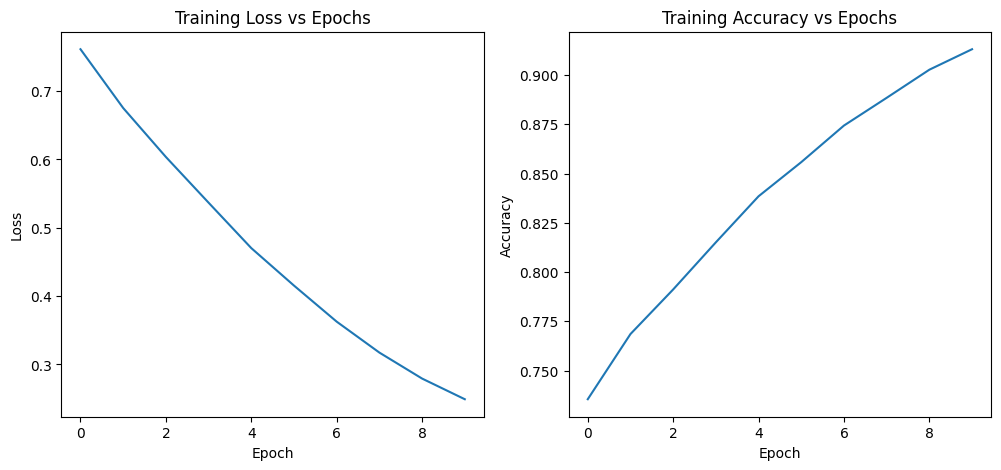

In [60]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accs)
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()


## 12. Evaluation on CIFAR-10 Test Set

In [61]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


## 13. Confusion Matrix

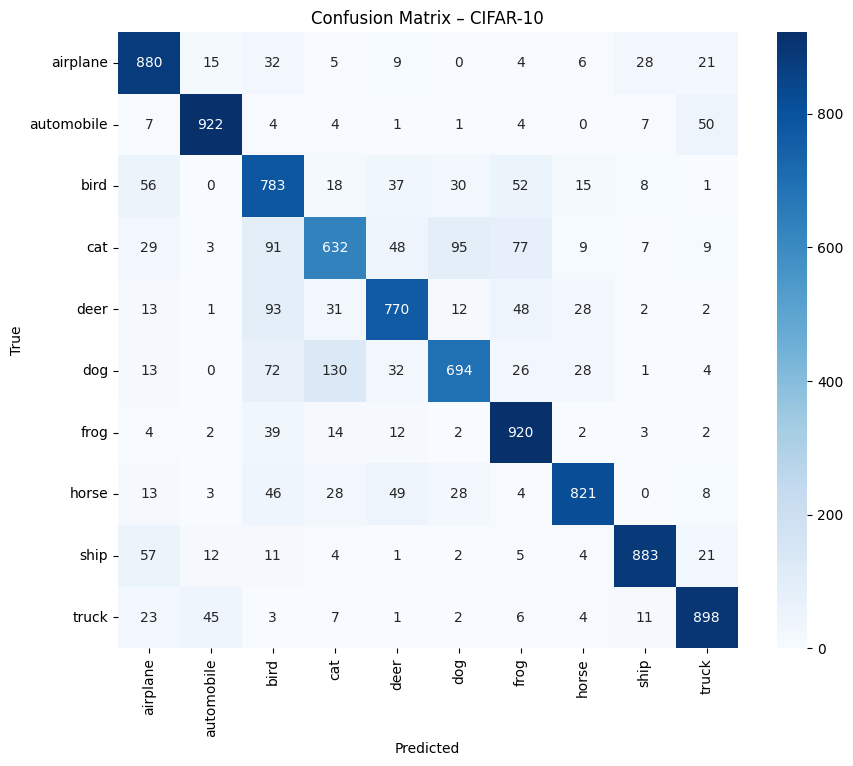

In [62]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes,
            yticklabels=classes,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – CIFAR-10")
plt.show()


## 14. Custom Smartphone Image Prediction (REAL-WORLD TESTING)

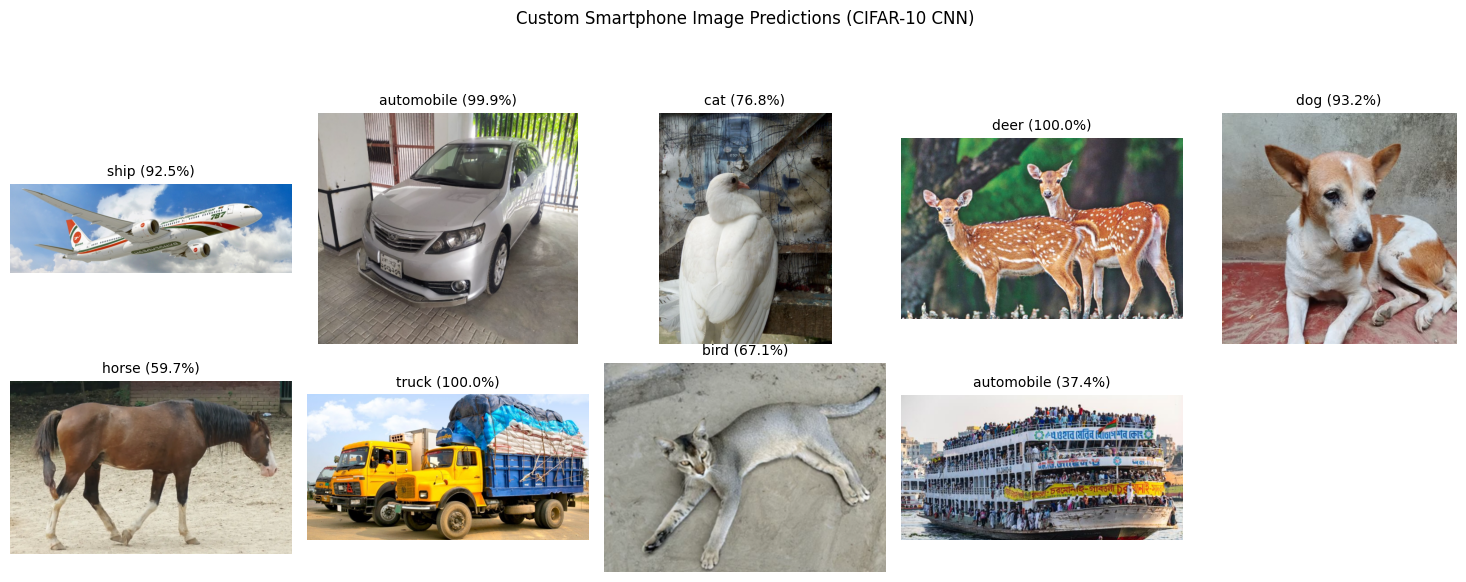

In [63]:
custom_dir = "data/custom"
images = sorted(os.listdir(custom_dir))  # keep order stable

model.eval()
plt.figure(figsize=(15, 6))

for i, img_name in enumerate(images):
    img_path = os.path.join(custom_dir, img_name)
    img = Image.open(img_path).convert("RGB")

    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(
        f"{classes[pred.item()]} ({conf.item()*100:.1f}%)",
        fontsize=10
    )
    plt.axis("off")

plt.suptitle("Custom Smartphone Image Predictions (CIFAR-10 CNN)")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


 **The confusion between bird and cat arises due to the low resolution of CIFAR-10 images (32×32), which limits the model’s ability to learn fine-grained biological features.
When applied to real-world smartphone images, the CNN relies primarily on coarse texture and shape cues, leading to misclassification between visually similar animal classes.
This highlights the generalization challenge of CNNs trained on small, low-resolution datasets.**

## 15. Visual Error Analysis (3 Misclassified Samples)

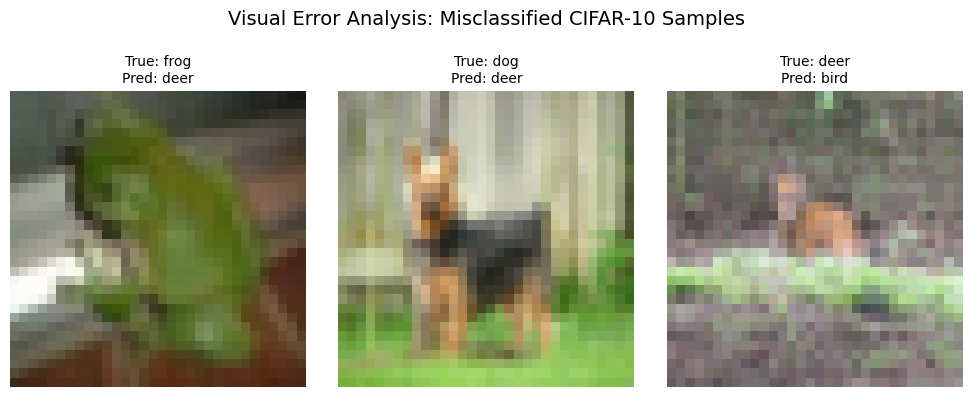

In [65]:
incorrect = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for img, true_label, pred_label in zip(images, labels, preds):
            if true_label != pred_label:
                incorrect.append(
                    (img.cpu(), true_label.item(), pred_label.item())
                )

            if len(incorrect) == 3:
                break

        if len(incorrect) == 3:
            break

plt.figure(figsize=(10, 4))

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std  = torch.tensor([0.2470, 0.2435, 0.2616])

for i, (img, true_cls, pred_cls) in enumerate(incorrect):
    plt.subplot(1, 3, i + 1)

    img = img.permute(1, 2, 0)
    img = img * std + mean
    img = img.clamp(0, 1)

    plt.imshow(img)
    plt.title(f"True: {classes[true_cls]}\nPred: {classes[pred_cls]}", fontsize=10)
    plt.axis("off")

plt.suptitle("Visual Error Analysis: Misclassified CIFAR-10 Samples", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
